In [ ]:
 ###### THIS IS NOT CITED YET ######

# imports

In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import collections
import sys
import glob
import random

import keras
from keras.layers import *
from keras.utils import np_utils
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, ModelCheckpoint
from keras.applications import DenseNet121, DenseNet169
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras.utils import Sequence
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras import activations

import cv2
from collections import Counter
from math import ceil, floor
from copy import deepcopy
from tqdm import tqdm_notebook as tqdm
from imgaug import augmenters as iaa

import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder



In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils.vis_utils import plot_model

In [ ]:
!pip install efficientnet
!pip install iterative-stratification

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 3.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Datasets 

uploading datasets

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
fertrain = "/content/drive/MyDrive/Colab_Data/FinalProject/fer/train" 
fertest = "/content/drive/MyDrive/Colab_Data/FinalProject/fer/test"

In [ ]:
fer2013plustrain = '/content/drive/MyDrive/Colab_Data/FinalProject/FERPlus/data/FER2013Test'
fer2013plustest = '/content/drive/MyDrive/Colab_Data/FinalProject/FERPlus/data/FER2013Test'

# VGG16

https://www.kaggle.com/code/samsonbezu/fer-with-vgg-16-and-vgg-19

In [ ]:
def merge_history(hlist):
    history = {}
    for k in hlist[0].history.keys():
        history[k] = sum([h.history[k] for h in hlist], [])
    return history

def vis_training(h, start=1):
    epoch_range = range(start, len(h['loss'])+1)
    s = slice(start-1, None)

    plt.figure(figsize=[14,4])

    n = int(len(h.keys()) / 2)

    for i in range(n):
        k = list(h.keys())[i]
        plt.subplot(1,n,i+1)
        plt.plot(epoch_range, h[k][s], label='Training')
        plt.plot(epoch_range, h['val_' + k][s], label='Validation')
        plt.xlabel('Epoch'); plt.ylabel(k); plt.title(k)
        plt.grid()
        plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab_Data/FinalProject/challenges_in_representation/train.csv')

In [ ]:
print(train_df.shape)

(28709, 2)


In [ ]:
train_df.head(10)

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
5,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...
6,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
7,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
8,3,85 84 90 121 101 102 133 153 153 169 177 189 1...
9,2,255 254 255 254 254 179 122 107 95 124 149 150...


label distribution

In [ ]:
(train_df.emotion.value_counts() / len(train_df)).to_frame().sort_index().T

,0,1,2,3,4,5,6
emotion,0.139155,0.015187,0.142708,0.251315,0.16824,0.110453,0.172942


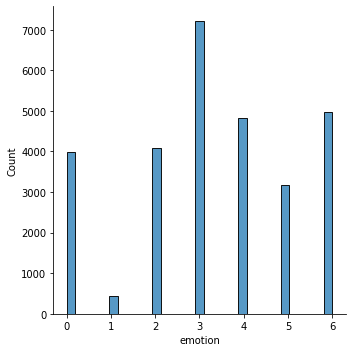

In [ ]:
sns.displot(train_df, x=train_df.emotion)

Observe Samples of Images

In [ ]:
emotion_label = {0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

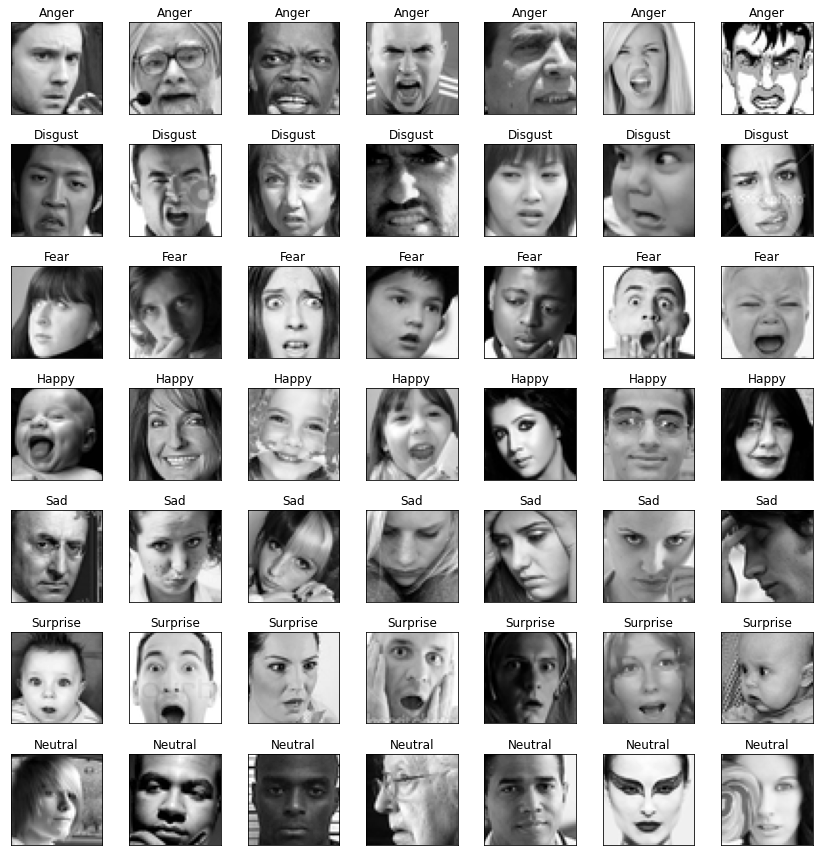

In [ ]:
fig = plt.figure(1, (12,12))
k=0

for label in sorted(train_df.emotion.unique()):
    for j in range(7):
        px = train_df[train_df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48,48).astype('float32')
        
        k += 1
        ax = plt.subplot(7,7,k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label[label])
        plt.tight_layout()

Data Generators

In [ ]:
train_df['pixels'] = [np.fromstring(x, dtype=int, sep=' ').reshape(-1,48,48,1) for x in train_df['pixels']]
img_array = np.concatenate(train_df.pixels)

le = LabelEncoder()
#One-hit-encoded labels
img_labels = le.fit_transform(train_df.emotion)
img_labels = np_utils.to_categorical(img_labels)

In [ ]:
print('Pixel Shape: ', img_array.shape)
print('Label Shape: ', img_labels.shape)

Pixel Shape:  (28709, 48, 48, 1)
Label Shape:  (28709, 7)


Split Datasets

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels, shuffle=True, stratify=img_labels, test_size=0.2, random_state=1)

print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(22967, 48, 48, 1) (5742, 48, 48, 1) (22967, 7) (5742, 7)


In [ ]:
Xs_train = X_train / 255
Xs_valid = X_valid / 255

In [ ]:
#Used for Model
X_train_color = np.repeat(Xs_train, repeats=3, axis=3)
X_valid_color = np.repeat(Xs_valid, repeats=3, axis=3)
print(X_train_color.shape)
print(X_valid_color.shape)

(22967, 48, 48, 3)
(5742, 48, 48, 3)


Load base model

58889256/58889256 [==============================] - 0s 0us/step


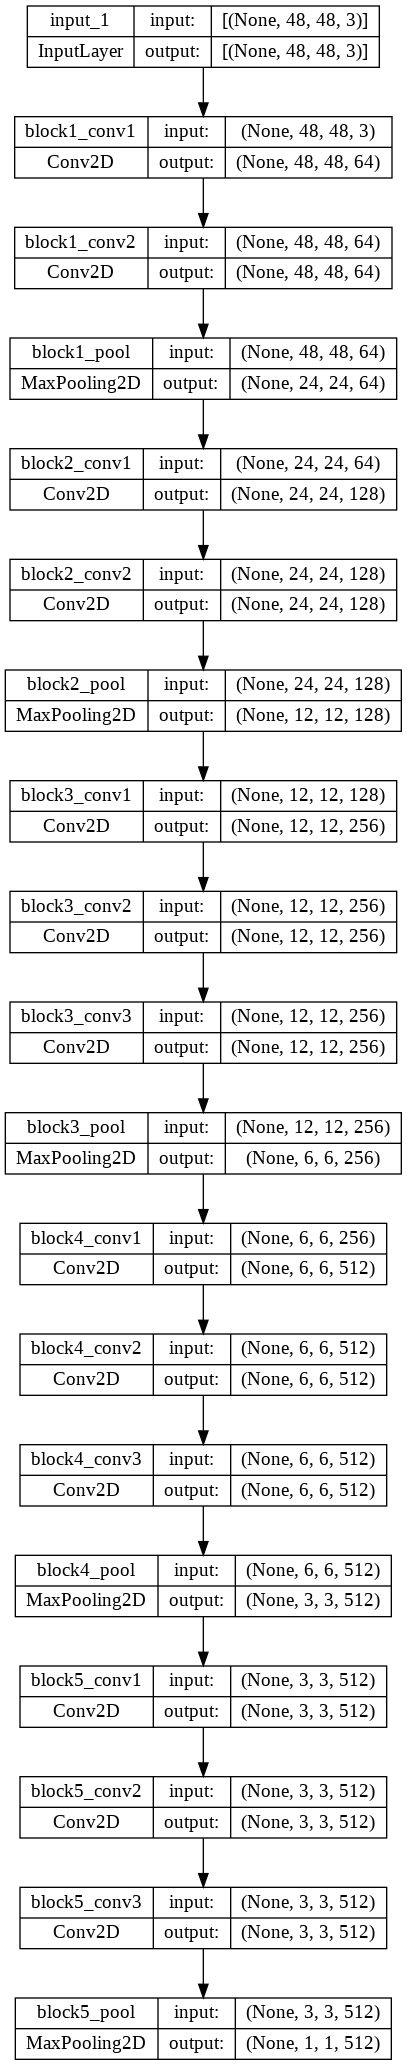

In [ ]:
base_model = tf.keras.applications.VGG16(
    input_shape = (48, 48, 3), 
    include_top = False, 
    weights = 'imagenet'
)

#Start with a non trainable model
base_model.trainable = False

tf.keras.utils.plot_model(base_model, show_shapes=True)

In [ ]:
base_model.summary()
len(base_model.layers)

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

19

Build a new model

In [ ]:
np.random.seed(7)
tf.random.set_seed(7)

cnn = Sequential ([
    base_model,
    

    Flatten(),
    
    Dense(64, activation='relu'),
    Dropout(0.50),
    Dense(32, activation='relu'),
    Dropout(0.25),
    Dense(32, activation='relu'),
    Dropout(0.15),
    Dense(7, activation='softmax')
])

cnn.summary()
len(cnn.layers)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                1

9

Training model

In [ ]:
opt = Adam(0.00001)
cnn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
%%time

h1 = cnn.fit(
    X_train_color,y_train,
    steps_per_epoch=len(X_train_color) / 64,
    epochs=50,
    validation_data=(X_valid_color,y_valid),
    validation_steps=len(X_valid_color) / 64,
    verbose=1
)

Epoch 1/50
358/358 [==============================] - 25s 67ms/step - loss: 1.8098 - accuracy: 0.2513 - val_loss: 1.8096 - val_accuracy: 0.2513
Epoch 2/50
358/358 [==============================] - 24s 66ms/step - loss: 1.8098 - accuracy: 0.2513 - val_loss: 1.8096 - val_accuracy: 0.2513
Epoch 3/50
358/358 [==============================] - 24s 68ms/step - loss: 1.8100 - accuracy: 0.2513 - val_loss: 1.8096 - val_accuracy: 0.2513
Epoch 4/50
358/358 [==============================] - 23s 65ms/step - loss: 1.8099 - accuracy: 0.2513 - val_loss: 1.8096 - val_accuracy: 0.2513
Epoch 5/50
358/358 [==============================] - 24s 66ms/step - loss: 1.8100 - accuracy: 0.2513 - val_loss: 1.8096 - val_accuracy: 0.2513
Epoch 6/50
358/358 [==============================] - 23s 65ms/step - loss: 1.8098 - accuracy: 0.2513 - val_loss: 1.8096 - val_accuracy: 0.2513
Epoch 7/50
358/358 [==============================] - 24s 68ms/step - loss: 1.8098 - accuracy: 0.2513 - val_loss: 1.8096 - val_accuracy:

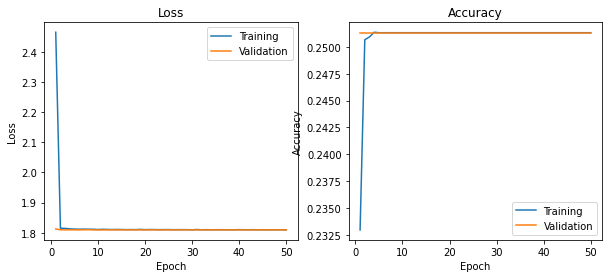

In [ ]:
history = h1.history
n_epochs = len(history['loss'])

plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.plot(range(1, n_epochs+1), history['loss'], label='Training')
plt.plot(range(1, n_epochs+1), history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1, n_epochs+1), history['accuracy'], label='Training')
plt.plot(range(1, n_epochs+1), history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.show()

Train run 2 

In [ ]:
base_model.trainable = True
opt = tf.keras.optimizers.Adam(0.0001)
cnn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
%%time

h2 = cnn.fit(
    X_train_color,y_train,
    steps_per_epoch=len(X_train_color) / 64,
    epochs=35,
    validation_data=(X_valid_color,y_valid),
    validation_steps=len(X_valid_color) / 64,
    verbose=1
)

Epoch 1/35
358/358 [==============================] - 25s 70ms/step - loss: 0.0765 - accuracy: 0.9716 - val_loss: 3.8177 - val_accuracy: 0.6061
Epoch 2/35
358/358 [==============================] - 25s 70ms/step - loss: 0.0743 - accuracy: 0.9720 - val_loss: 4.0169 - val_accuracy: 0.6094
Epoch 3/35
358/358 [==============================] - 24s 68ms/step - loss: 0.0753 - accuracy: 0.9709 - val_loss: 4.0872 - val_accuracy: 0.6005
Epoch 4/35
358/358 [==============================] - 25s 69ms/step - loss: 0.0726 - accuracy: 0.9725 - val_loss: 4.0069 - val_accuracy: 0.6116
Epoch 5/35
358/358 [==============================] - 25s 69ms/step - loss: 0.0752 - accuracy: 0.9711 - val_loss: 3.9530 - val_accuracy: 0.6082
Epoch 6/35
358/358 [==============================] - 25s 69ms/step - loss: 0.0754 - accuracy: 0.9716 - val_loss: 4.0961 - val_accuracy: 0.6057
Epoch 7/35
358/358 [==============================] - 25s 69ms/step - loss: 0.0768 - accuracy: 0.9708 - val_loss: 3.9919 - val_accuracy:

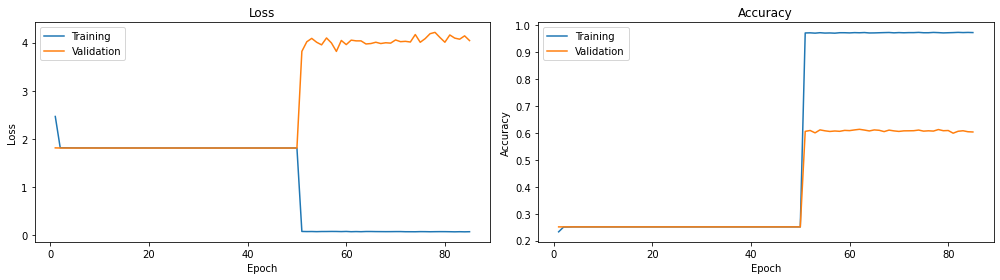

In [ ]:
for k in history.keys():
    history[k] += h2.history[k]

epoch_range = range(1, len(history['loss'])+1)

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

Fine Tuning

In [ ]:
base_model.trainable = True
opt = tf.keras.optimizers.Adam(0.000001)
cnn.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                1

In [ ]:
%%time

h3 = cnn.fit(
    X_train_color,y_train,
    steps_per_epoch=len(X_train_color) / 64,
    epochs=100,
    validation_data=(X_valid_color,y_valid),
    validation_steps=len(X_valid_color) / 64,
    verbose=1
)

Epoch 1/100
358/358 [==============================] - 26s 69ms/step - loss: 0.0714 - accuracy: 0.9725 - val_loss: 4.0723 - val_accuracy: 0.6061
Epoch 2/100
358/358 [==============================] - 25s 70ms/step - loss: 0.0707 - accuracy: 0.9727 - val_loss: 4.2587 - val_accuracy: 0.6076
Epoch 3/100
358/358 [==============================] - 25s 69ms/step - loss: 0.0680 - accuracy: 0.9738 - val_loss: 4.1985 - val_accuracy: 0.6022
Epoch 4/100
358/358 [==============================] - 25s 69ms/step - loss: 0.0704 - accuracy: 0.9730 - val_loss: 4.1612 - val_accuracy: 0.6061
Epoch 5/100
358/358 [==============================] - 25s 69ms/step - loss: 0.0695 - accuracy: 0.9730 - val_loss: 4.1182 - val_accuracy: 0.6064
Epoch 6/100
358/358 [==============================] - 25s 69ms/step - loss: 0.0684 - accuracy: 0.9733 - val_loss: 4.2958 - val_accuracy: 0.6028
Epoch 7/100
358/358 [==============================] - 25s 69ms/step - loss: 0.0697 - accuracy: 0.9726 - val_loss: 4.0783 - val_ac

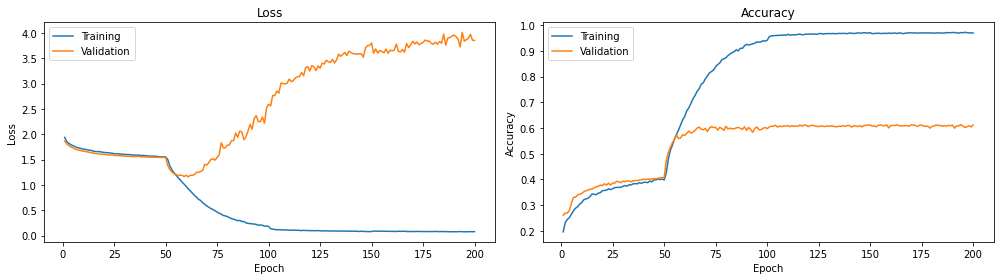

In [ ]:
for k in history.keys():
    history[k] += h3.history[k]

epoch_range = range(1, len(history['loss'])+1)

plt.figure(figsize=[14,4])
plt.subplot(1,2,1)
plt.plot(epoch_range, history['loss'], label='Training')
plt.plot(epoch_range, history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch_range, history['accuracy'], label='Training')
plt.plot(epoch_range, history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

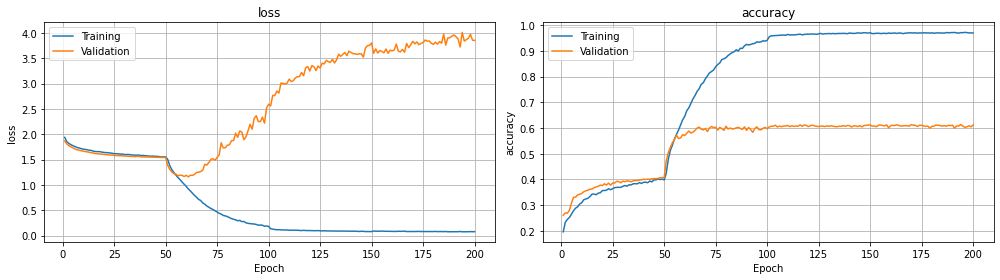

In [ ]:
history = merge_history([h1])
vis_training(history)

In [ ]:
cnn.save(f'FER_VGG16_v01.h5')
pickle.dump(history, open(f'FER_VGG16_v01_history.pkl', 'wb'))

# Models - deep shape = 25 layers works on all sets

In [ ]:
model= tf.keras.models.Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(512,(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,(3,3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten()) 
model.add(Dense(256,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
    
model.add(Dense(512,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

In [ ]:
train_datagen = ImageDataGenerator(width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [ ]:
img_size=48

In [ ]:
model.compile(
    optimizer = Adam(learning_rate=0.001), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

In [ ]:
epochs = 50
batch_size = 64

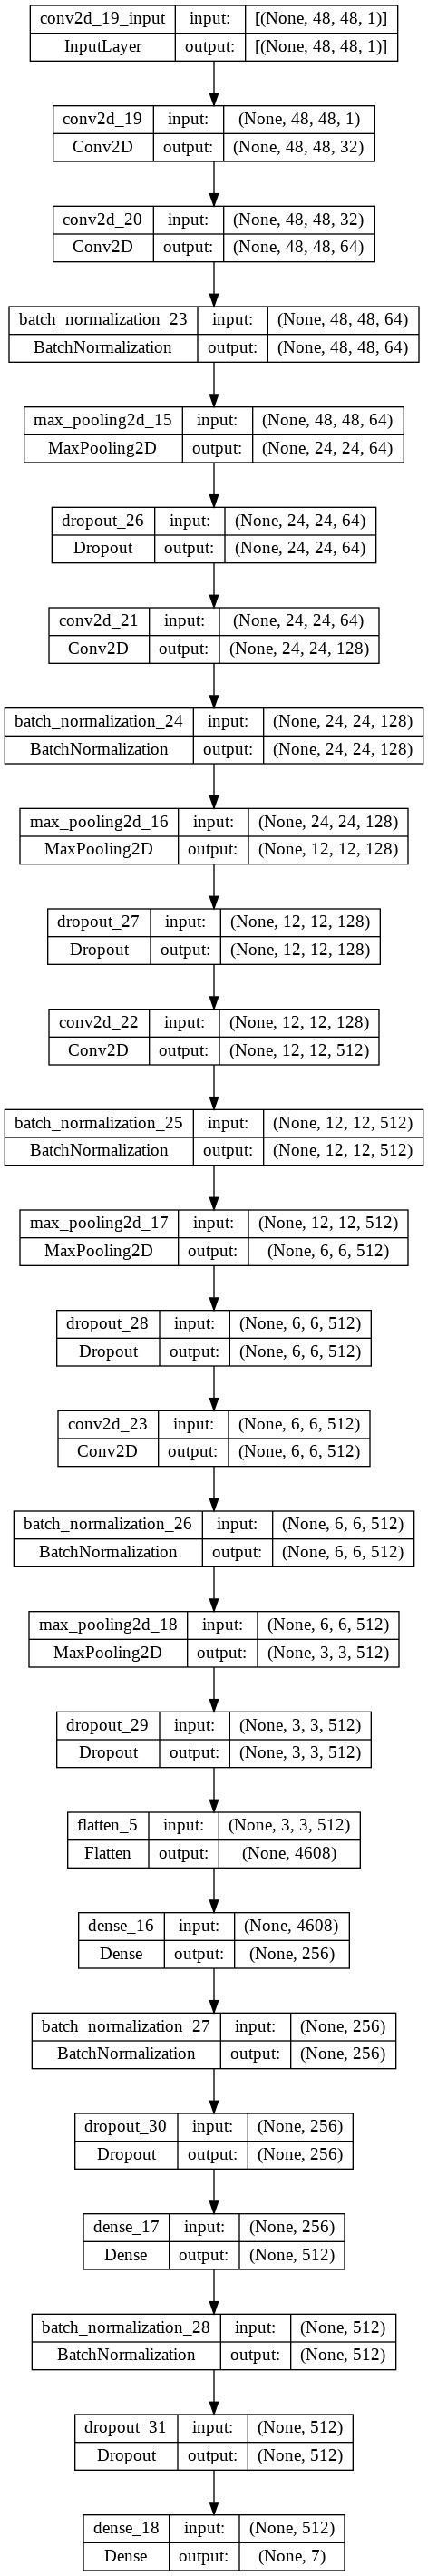

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.summary()
len(model.layers)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 conv2d_20 (Conv2D)          (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_23 (Bat  (None, 48, 48, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 24, 24, 64)       0         
 g2D)                                                            
                                                                 
 dropout_26 (Dropout)        (None, 24, 24, 64)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 24, 24, 128)      

25

# FER

In [ ]:
train_generator = train_datagen.flow_from_directory(directory = fertrain,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = fertest,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                             )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


Parameters for this:


In [ ]:
historyfer1 = model.fit(x = train_generator,epochs = epochs,validation_data = validation_generator)

Epoch 1/50
359/359 [==============================] - 4080s 11s/step - loss: 2.0877 - accuracy: 0.2294 - val_loss: 1.7930 - val_accuracy: 0.2744
Epoch 2/50
359/359 [==============================] - 47s 132ms/step - loss: 1.7390 - accuracy: 0.3258 - val_loss: 1.8729 - val_accuracy: 0.3429
Epoch 3/50
359/359 [==============================] - 47s 132ms/step - loss: 1.5300 - accuracy: 0.4104 - val_loss: 1.4232 - val_accuracy: 0.4651
Epoch 4/50
359/359 [==============================] - 48s 133ms/step - loss: 1.3548 - accuracy: 0.4792 - val_loss: 1.3112 - val_accuracy: 0.5014
Epoch 5/50
359/359 [==============================] - 47s 130ms/step - loss: 1.2643 - accuracy: 0.5201 - val_loss: 1.1732 - val_accuracy: 0.5670
Epoch 6/50
359/359 [==============================] - 47s 131ms/step - loss: 1.2124 - accuracy: 0.5403 - val_loss: 1.1575 - val_accuracy: 0.5391
Epoch 7/50
359/359 [==============================] - 50s 139ms/step - loss: 1.1771 - accuracy: 0.5526 - val_loss: 1.1515 - val_ac

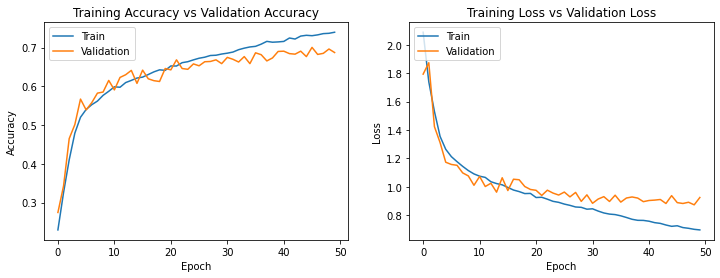

In [ ]:
fig , ax = plt.subplots(1,2)
train_acc = historyfer1.history['accuracy']
train_loss = historyfer1.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(historyfer1.history['accuracy'])
ax[0].plot(historyfer1.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(historyfer1.history['loss'])
ax[1].plot(historyfer1.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

# FER2013plus

In [ ]:
train_generator = train_datagen.flow_from_directory(directory = fer2013plustrain,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = fer2013plustest,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                             )

Found 5746 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [ ]:
historyfer2013plus = model.fit(x = train_generator,epochs = epochs,validation_data = validation_generator)

Epoch 1/50
90/90 [==============================] - 1111s 12s/step - loss: 1.0364 - accuracy: 0.6255 - val_loss: 0.8857 - val_accuracy: 0.6906
Epoch 2/50
90/90 [==============================] - 14s 154ms/step - loss: 0.9731 - accuracy: 0.6366 - val_loss: 0.8476 - val_accuracy: 0.6920
Epoch 3/50
90/90 [==============================] - 14s 151ms/step - loss: 0.9334 - accuracy: 0.6530 - val_loss: 0.8626 - val_accuracy: 0.6837
Epoch 4/50
90/90 [==============================] - 14s 152ms/step - loss: 0.9105 - accuracy: 0.6652 - val_loss: 0.8413 - val_accuracy: 0.6892
Epoch 5/50
90/90 [==============================] - 15s 170ms/step - loss: 0.8830 - accuracy: 0.6671 - val_loss: 0.8586 - val_accuracy: 0.6934
Epoch 6/50
90/90 [==============================] - 16s 176ms/step - loss: 0.8711 - accuracy: 0.6798 - val_loss: 0.8663 - val_accuracy: 0.6781
Epoch 7/50
90/90 [==============================] - 16s 174ms/step - loss: 0.8439 - accuracy: 0.6817 - val_loss: 0.8838 - val_accuracy: 0.6746

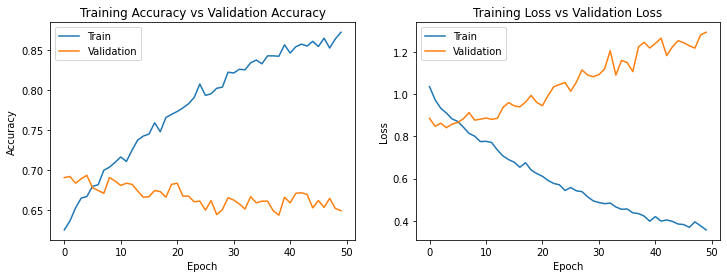

In [ ]:
fig , ax = plt.subplots(1,2)
train_acc = historyfer2013plus.history['accuracy']
train_loss = historyfer2013plus.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(historyfer2013plus.history['accuracy'])
ax[0].plot(historyfer2013plus.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(historyfer2013plus.history['loss'])
ax[1].plot(historyfer2013plus.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()